In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys
sys.path.append("incl/")

import noror

In [6]:
trajectories = noror.utils.load_trajectories(filename='../trajectories_n_kmax=200.npz')

trajectories = trajectories[::10]

n_trajectories = len(trajectories)
n_kmax = trajectories[0].shape[1]

print(n_trajectories, 'loaded with n_kmax =', n_kmax)

100 loaded with n_kmax = 200


runs[0] shape:  (400, 200)


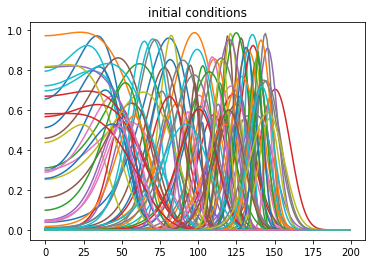

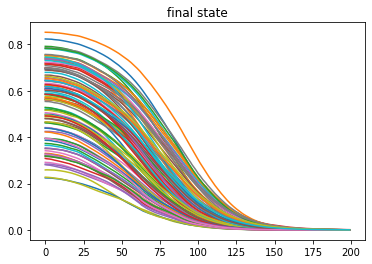

In [7]:
print('runs[0] shape: ', trajectories[0].shape)

for k in range(n_trajectories):
    plt.plot(trajectories[k][0])

plt.title('initial conditions')
plt.show()


for k in range(n_trajectories):
    plt.plot(trajectories[k][-1])

plt.title('final state')
plt.show()

In [9]:
dim_reducer = noror.dim_reducers.SVD()
# dim_reducer = noror.dim_reducers.DFT(sorted=True)
# dim_reducer = noror.dim_reducers.Hermite(sample_max = 1.0, sorted=True, optimize=True, orthogonalize=True, train_rdim=20)

# scaler = noror.scalers.normalize_scaler(0.1)
scaler = noror.scalers.standardize_scaler(1.0)
# scaler = noror.scalers.tanh_scaler(0.1)

# transformer = noror.transformers.polynomial_features(order=2)
transformer = noror.transformers.ELM_features(ELM_nodes=400)

optimizer = noror.optimizers.ridge(alpha=10.**-3)
# optimizer = noror.optimizers.lstsqrs()
# optimizer = noror.optimizers.stlsq(alpha=10.**-3, threshold=1e-3)
# optimizer = noror.optimizers.PIML_adam(dim_reducer=dim_reducer, alpha=1e-3, lambda1=100000, mini_batch_size=39000, epochs = 100)

model = noror.noror(trajectories, targets='AR', VAR_l=2, intercept=True, full_hist=False,
                    optimizer=optimizer,
                    scaler=scaler,
                    dim_reducer=dim_reducer,
                    VAR_transformer=transformer)

model.train(rdim=15)

model.print_status()


full_hist:  False
intercept:  True
standardize:  True
rdim:  15
VAR_l:  2
train shape:  (39900, 431)
target shape:  (39900, 15)
weights shape:  (431, 15)


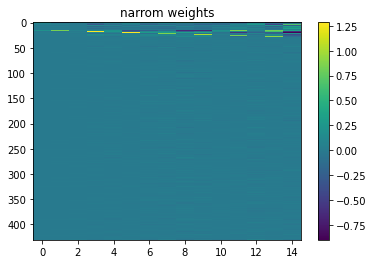

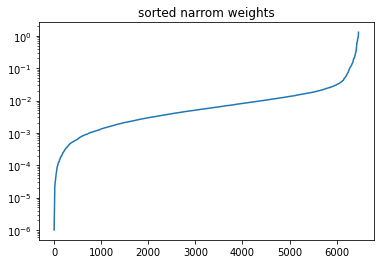

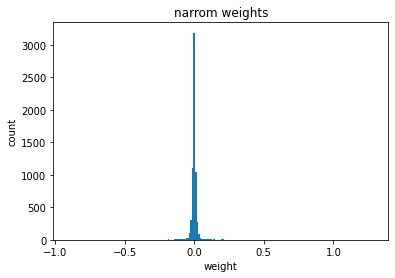

In [10]:
masked_weights = np.ma.masked_values(model.w,0.0)
plt.imshow(masked_weights, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('narrom weights')
plt.show()

plt.semilogy(np.sort(np.ravel(np.abs(model.w))))
plt.title('sorted narrom weights')
plt.show()

plt.hist(np.ravel(model.w), bins=200)
plt.title('narrom weights')
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

In [13]:

test_trajectory = noror.utils.load_trajectories(filename='/home/agluedge/Preprints/ELPH/example_run.npz')[0].T
print('example trajectory loaded with shape: ', test_trajectory.shape)


example trajectory loaded with shape:  (400, 200)


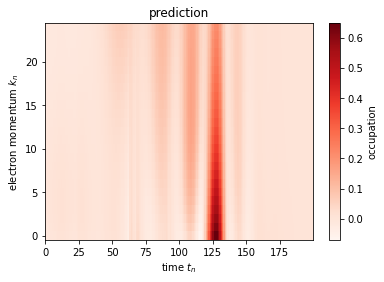

In [15]:
pred = model.forecast(test_trajectory[:1],25)
    
noror.utils.plot_trajectory(pred,'prediction')



In [16]:
pred = model.predict(test_trajectory)

print('std error: ', model.get_error(test_trajectory, pred=pred, norm='NF') )
print('max error: ', model.get_error(test_trajectory, pred=pred, norm='max') )

std error:  0.020215309308337096
max error:  0.11527242704808915


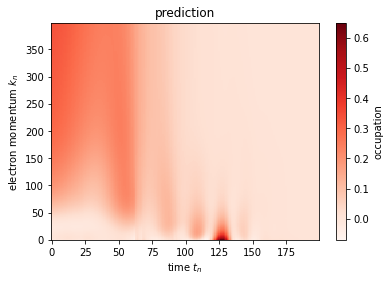

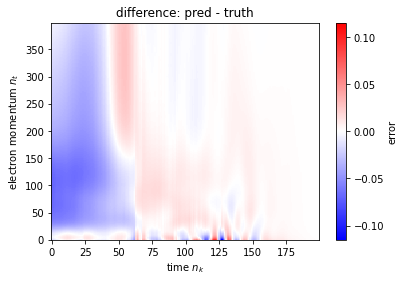

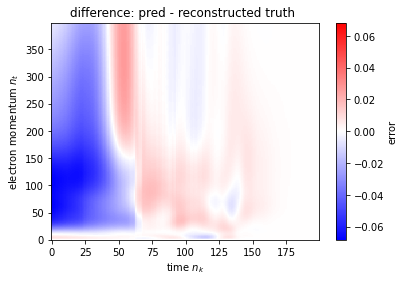

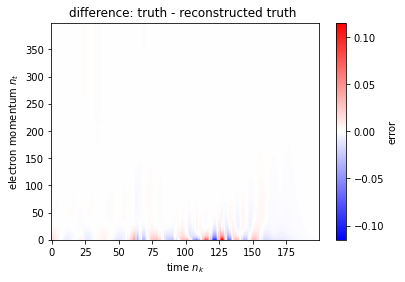

In [18]:

noror.utils.plot_trajectory(pred, 'prediction')

noror.utils.plot_difference(pred,test_trajectory,'difference: pred - truth')


test_trajectory_SVDapprx = dim_reducer.reconstruct( dim_reducer.reduce(test_trajectory,15) )

noror.utils.plot_difference(pred,test_trajectory_SVDapprx,'difference: pred - reconstructed truth ')

noror.utils.plot_difference(test_trajectory,test_trajectory_SVDapprx,'difference: truth - reconstructed truth ')


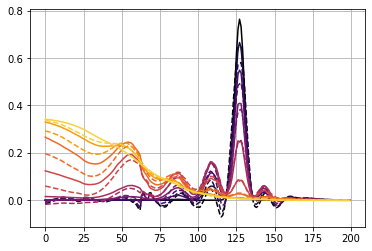

NF error:  0.020215309308337096
max abs error:  0.11527242704808915


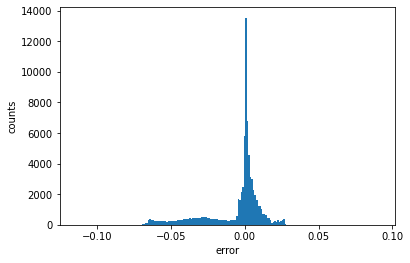

In [20]:
pl_colors = plt.get_cmap('inferno')

tn_arr = [0,2,5,10,20,50,100,200,399]

plt.grid()

for k,tn in enumerate(tn_arr):
    plt.plot(test_trajectory[tn], '-', c=pl_colors(k/len(tn_arr)))
    plt.plot(pred[tn], '--', c=pl_colors(k/len(tn_arr)))

plt.show()

print('NF error: ', model.get_error(truth=test_trajectory, pred=pred, norm='NF') )
print('max abs error: ', model.get_error(truth=test_trajectory, pred=pred, norm='max') )

plt.hist(np.ravel(pred-test_trajectory), bins = 200)
plt.xlabel('error')
plt.ylabel('counts')
plt.show()

In [31]:
dim_reducer = noror.dim_reducers.SVD()

# scaler = noror.scalers.normalize_scaler(0.1)
scaler = noror.scalers.standardize_scaler(1.0)

# transformer = noror.transformers.polynomial_features(order=2)
transformer = noror.transformers.ELM_features(ELM_nodes=400)

optimizer = noror.optimizers.ridge(alpha=10.**-3.0)

model = noror.noror(trajectories, targets='AR', VAR_l=2, intercept=True, full_hist=False, 
                      optimizer=optimizer,
                      scaler=scaler,
                      dim_reducer=dim_reducer,
                      VAR_transformer=transformer)

train_kwargs = {'rdim':15}

scores = noror.utils.get_KFold_CV_scores(model, trajectories, folds=10, seed=817,
                                          norms=['NF','max'],
                                          train_kwargs=train_kwargs)

print('NF error: ', str(np.mean(scores[0])) + ' +- ' + str(np.std(scores[0])) )
print('max error: ', str(np.mean(scores[1])) + ' +- ' + str(np.std(scores[1])) )

NF error:  0.01847578262257055 +- 0.017912853110393787
max error:  0.08236689560958199 +- 0.06492335237371531


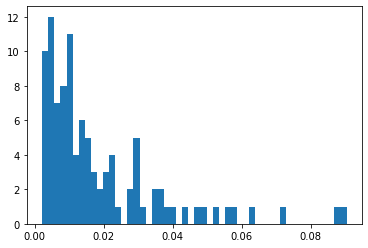

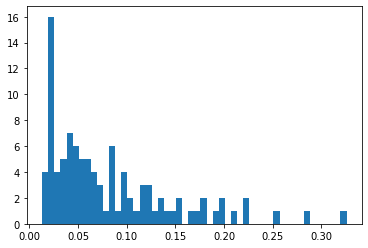

In [25]:
plt.hist(scores[0],bins=50)
plt.show()

plt.hist(scores[1],bins=50)
plt.show()